## 

# Differentiable Physics III: Thrust Vector Control

## Liquid Rocket Engine

Let us assume we have a rocket with a singel rocket engine which can be gimbaled. The first setup lets us control the direction and the magnitude of the thrust vector, becuase liquid rocket engines can be throttled.

In [2]:
import jax.numpy as jnp
from jax import value_and_grad, jit
from functools import partial

# Define the initial state of the rocket
x0 = jnp.array([0.0, 3.0])
v0 = jnp.array([1.0, -1.0])

# Define the target state of the rocket
xn_star = jnp.array([1.0, 0.0])
vn_star = jnp.array([0.0, 0.0])

simulation_steps = 50
dt = 0.1
m = 1.0

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
@partial(jit, static_argnames=('G'))
def force(x : jnp.ndarray, thrust : jnp.ndarray, G : float = 0.01) -> jnp.ndarray:
    return -G * jnp.array([0, -1]) + thrust

@partial(jit, static_argnames=('dt', 'm'))
def verlet_step(
    x : jnp.ndarray,
    v : jnp.ndarray,
    dt : float,
    m : float, 
    thrust : jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:

    x_fwd = jnp.asarray(x) + (v * dt) + (0.5 * force(x, thrust) * dt * dt / m)
    v_fwd = jnp.asarray(v) + (0.5 * (force(x, thrust) + force(x_fwd, thrust)) * dt / m)

    return x_fwd, v_fwd

We want optimize three things:

1. The velocity of the rocket at the end of the simulation
2. The position of the rocket at the end of the simulation
3. The fuel consumption of the rocket

In [4]:
def simulation_loss(
    x0 : jnp.ndarray,
    v0 : jnp.ndarray,
    xn_star : jnp.ndarray,
    vn_star : jnp.ndarray,
    thrust_vectors : jnp.ndarray,
    simulation_steps : int,
    dt : float = 0.01,
    m : float = 1.0) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:

    x = x0.copy()
    v = v0.copy()

    for i in range(0, simulation_steps):
        x, v = verlet_step(x, v, dt, m, thrust_vectors[i])

    return jnp.mean(jnp.square(x - xn_star)) + jnp.mean(jnp.square(v - vn_star)) + jnp.mean(jnp.square(thrust_vectors))

In [5]:
loss_and_grad = value_and_grad(simulation_loss, argnums=4)

Lets start the gradient descent with initial thrusts of zeros. 

In [6]:
optimization_steps = 40
learning_rate = 0.2

thrust_vectors = jnp.zeros((simulation_steps, 2))

thrust_vectors_history = []

for i in range(0, optimization_steps):
    loss, gradient_thrust = loss_and_grad(x0, v0, xn_star, vn_star, thrust_vectors, simulation_steps, dt, m)

    thrust_vectors -= gradient_thrust * learning_rate
    thrust_vectors_history.append(thrust_vectors.copy())

    print(f'Loss: {loss}')


Loss: 10.709057807922363
Loss: 0.20804840326309204
Loss: 0.12732435762882233
Loss: 0.12319701910018921
Loss: 0.11981888115406036
Loss: 0.11662358045578003
Loss: 0.11359786987304688
Loss: 0.1107325479388237
Loss: 0.10801921784877777
Loss: 0.10544981062412262
Loss: 0.10301649570465088
Loss: 0.1007123738527298
Loss: 0.09853044152259827
Loss: 0.09646407514810562
Loss: 0.09450732171535492
Loss: 0.09265445917844772
Loss: 0.09089969098567963
Loss: 0.08923803269863129
Loss: 0.08766458183526993
Loss: 0.0861743688583374
Loss: 0.08476334810256958
Loss: 0.08342704176902771
Loss: 0.08216170966625214
Loss: 0.08096341788768768
Loss: 0.07982867956161499
Loss: 0.07875408232212067
Loss: 0.0777365118265152
Loss: 0.07677289098501205
Loss: 0.07586032152175903
Loss: 0.07499617338180542
Loss: 0.07417792081832886
Loss: 0.07340292632579803
Loss: 0.07266907393932343
Loss: 0.07197417318820953
Loss: 0.07131615281105042
Loss: 0.07069292664527893
Loss: 0.07010283321142197
Loss: 0.0695440024137497
Loss: 0.0690147876

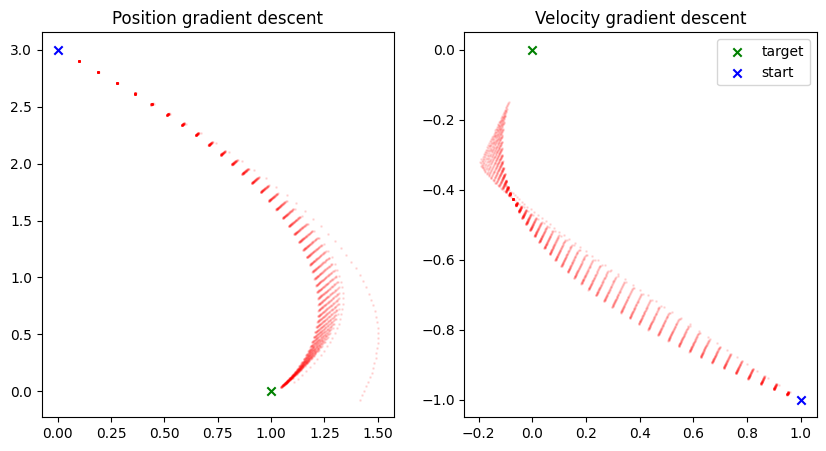

In [7]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for j in range(0, optimization_steps):
    
    x = x0.copy()
    v = v0.copy()
    xs = jnp.zeros((simulation_steps, 2))
    vs = jnp.zeros((simulation_steps, 2))
    for i in range(0, simulation_steps):
        x, v = verlet_step(x, v, dt, m, thrust_vectors_history[j][i])
        xs = xs.at[i].set(x)
        vs = vs.at[i].set(v)

    axs[0].scatter(xs[:, 0], xs[:, 1], color='red', alpha=0.1, marker='o', s=1)
    axs[1].scatter(vs[:, 0], vs[:, 1], color='red', alpha=0.1, marker='o', s=1)

axs[0].scatter(xn_star[0], xn_star[1], label='target', color='green', marker='x')
axs[0].scatter(x0[0], x0[1], label='start', color='blue', marker='x')

axs[1].scatter(vn_star[0], vn_star[1], label='target', color='green', marker='x')
axs[1].scatter(v0[0], v0[1], label='start', color='blue', marker='x')

axs[0].set_title('Position gradient descent')
axs[1].set_title('Velocity gradient descent')


plt.legend()


## Solid State Rocket Engine

Lets consider a rocket with a single solid-propellant rocket engine. The engine is gimbaled, meaning that it can be rotated about a single axis. This allows the rocket to control its attitude and thus its trajectory. The gimbal angle is controlled by a single variable, $\theta$. The thrust vector is then given by

$$
\mathbf{T} = T \begin{bmatrix} \sin \theta \\ \cos \theta \end{bmatrix}
$$

where $T$ is the thrust magnitude. 

In [30]:
# Define the initial state of the rocket
x0 = jnp.array([0.0, 3.0])
v0 = jnp.array([1.0, -1.0])

# Define the target state of the rocket
xn_star = jnp.array([1.0, 0.0])
vn_star = jnp.array([0.0, 0.0])

simulation_steps = 50
dt = 0.1
m = 1.0

In [31]:
@partial(jit, static_argnames=('G'))
def force(x : jnp.ndarray, theta : float, magnitude : float = 1.0, G : float = 0.01) -> jnp.ndarray:
    return -G * jnp.array([0, -1]) + magnitude * jnp.array([jnp.cos(theta), jnp.sin(theta)])

@partial(jit, static_argnames=('dt', 'm'))
def verlet_step(
    x : jnp.ndarray,
    v : jnp.ndarray,
    dt : float,
    m : float, 
    theta : jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:

    x_fwd = jnp.asarray(x) + (v * dt) + (0.5 * force(x, theta) * dt * dt / m)
    v_fwd = jnp.asarray(v) + (0.5 * (force(x, theta) + force(x_fwd, theta)) * dt / m)

    return x_fwd, v_fwd

This time we only want to optimize two things:

1. The velocity of the rocket at the end of the simulation
2. The position of the rocket at the end of the simulation

As the thrust vector is now fixed, there is no need to optimize the fuel consumption.

In [32]:
def simulation_loss(
    x0 : jnp.ndarray,
    v0 : jnp.ndarray,
    xn_star : jnp.ndarray,
    vn_star : jnp.ndarray,
    thrust_thetas : jnp.ndarray,
    simulation_steps : int,
    dt : float = 0.01,
    m : float = 1.0) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:

    x = x0.copy()
    v = v0.copy()

    for i in range(0, simulation_steps):
        x, v = verlet_step(x, v, dt, m, thrust_thetas[i])

    return jnp.mean(jnp.square(x - xn_star)) + jnp.mean(jnp.square(v - vn_star))

In [33]:
loss_and_grad = value_and_grad(simulation_loss, argnums=4)

In [34]:
from jax import random

optimization_steps = 100
learning_rate = 0.6

thrust_thetas = random.uniform(random.PRNGKey(0), (simulation_steps, ), minval=0.0, maxval=2.0 * jnp.pi)

thrust_thetas_history = []

for i in range(0, optimization_steps):
    loss, gradient_thrust = loss_and_grad(x0, v0, xn_star, vn_star, thrust_thetas, simulation_steps, dt, m)
    thrust_thetas -= gradient_thrust * learning_rate
    thrust_thetas_history.append(thrust_thetas.copy())

    print(f'Loss: {loss}')


Loss: 2.760572910308838
Loss: 0.44056981801986694
Loss: 0.13468869030475616
Loss: 0.10749903321266174
Loss: 0.0931439995765686
Loss: 0.08398549258708954
Loss: 0.07705581188201904
Loss: 0.07122161239385605
Loss: 0.06603193283081055
Loss: 0.061298906803131104
Loss: 0.056936584413051605
Loss: 0.05289808660745621
Loss: 0.049152933061122894
Loss: 0.04567757993936539
Loss: 0.042451635003089905
Loss: 0.03945734351873398
Loss: 0.0366777628660202
Loss: 0.03409755602478981
Loss: 0.03170258179306984
Loss: 0.029479317367076874
Loss: 0.027415448799729347
Loss: 0.025499409064650536
Loss: 0.023720525205135345
Loss: 0.022068815305829048
Loss: 0.020535023882985115
Loss: 0.019110625609755516
Loss: 0.017787650227546692
Loss: 0.016558781266212463
Loss: 0.015417087823152542
Loss: 0.014356319792568684
Loss: 0.013370540924370289
Loss: 0.0124543197453022
Loss: 0.011602642014622688
Loss: 0.010810835286974907
Loss: 0.01007457822561264
Loss: 0.009389879181981087
Loss: 0.008753045462071896
Loss: 0.008160536177456

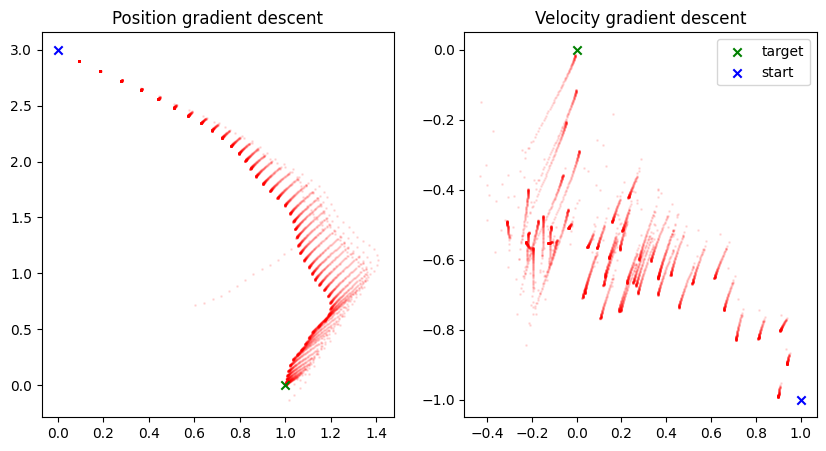

In [35]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for j in range(0, optimization_steps):
    
    x = x0.copy()
    v = v0.copy()
    xs = jnp.zeros((simulation_steps, 2))
    vs = jnp.zeros((simulation_steps, 2))
    for i in range(0, simulation_steps):
        x, v = verlet_step(x, v, dt, m, thrust_thetas_history[j][i])
        xs = xs.at[i].set(x)
        vs = vs.at[i].set(v)

    axs[0].scatter(xs[:, 0], xs[:, 1], color='red', alpha=0.1, marker='o', s=1)
    axs[1].scatter(vs[:, 0], vs[:, 1], color='red', alpha=0.1, marker='o', s=1)

axs[0].scatter(xn_star[0], xn_star[1], label='target', color='green', marker='x')
axs[0].scatter(x0[0], x0[1], label='start', color='blue', marker='x')

axs[1].scatter(vn_star[0], vn_star[1], label='target', color='green', marker='x')
axs[1].scatter(v0[0], v0[1], label='start', color='blue', marker='x')

axs[0].set_title('Position gradient descent')
axs[1].set_title('Velocity gradient descent')


plt.legend()


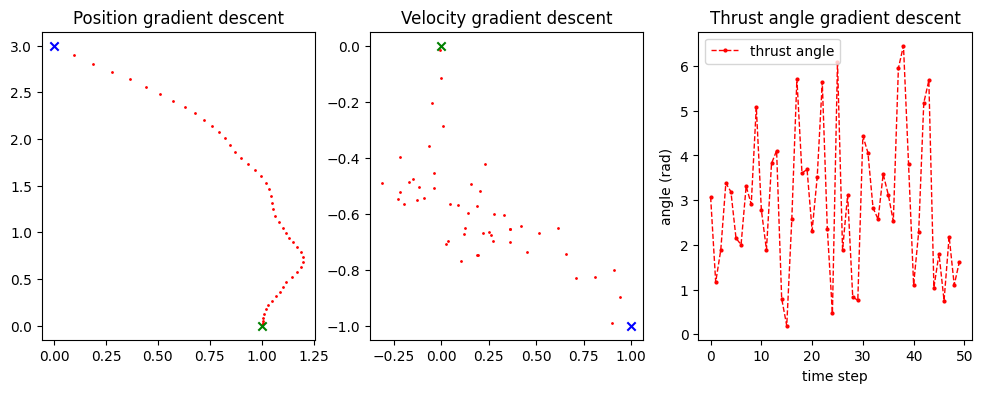

In [36]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


x = x0.copy()
v = v0.copy()
xs = jnp.zeros((simulation_steps, 2))
vs = jnp.zeros((simulation_steps, 2))
for i in range(0, simulation_steps):
    x, v = verlet_step(x, v, dt, m, thrust_thetas_history[-1][i])
    xs = xs.at[i].set(x)
    vs = vs.at[i].set(v)

axs[0].scatter(xs[:, 0], xs[:, 1], color='red', alpha=1.0, marker='o', s=1)
axs[1].scatter(vs[:, 0], vs[:, 1], color='red', alpha=1.0, marker='o', s=1)

axs[0].scatter(xn_star[0], xn_star[1], label='target', color='green', marker='x')
axs[0].scatter(x0[0], x0[1], label='start', color='blue', marker='x')

axs[1].scatter(vn_star[0], vn_star[1], label='target', color='green', marker='x')
axs[1].scatter(v0[0], v0[1], label='start', color='blue', marker='x')

axs[2].plot(thrust_thetas_history[-1], label='thrust angle', color='red', marker='o', markersize=2, linestyle='dashed', linewidth=1)
axs[2].set_title('Thrust angle')
axs[2].set_xlabel('time step')
axs[2].set_ylabel('angle (rad)')


axs[0].set_title('Position gradient descent')
axs[1].set_title('Velocity gradient descent')
axs[2].set_title('Thrust angle gradient descent')


plt.legend()


Lets update the loss function, such that the change of the thust vector angle is penalized.

In [37]:
def simulation_loss(
    x0 : jnp.ndarray,
    v0 : jnp.ndarray,
    xn_star : jnp.ndarray,
    vn_star : jnp.ndarray,
    thrust_thetas : jnp.ndarray,
    simulation_steps : int,
    dt : float = 0.01,
    m : float = 1.0) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:

    x = x0.copy()
    v = v0.copy()

    for i in range(0, simulation_steps):
        x, v = verlet_step(x, v, dt, m, thrust_thetas[i])

    return jnp.mean(jnp.square(x - xn_star)) + jnp.mean(jnp.square(v - vn_star)) + jnp.mean(jnp.square(thrust_thetas - jnp.roll(thrust_thetas, 1)))

loss_and_grad = value_and_grad(simulation_loss, argnums=4)

In [38]:
optimization_steps = 100
learning_rate = 0.6

thrust_thetas = random.uniform(random.PRNGKey(0), (simulation_steps, ), minval=0.0, maxval=2.0 * jnp.pi)

thrust_thetas_history = []

for i in range(0, optimization_steps):
    loss, gradient_thrust = loss_and_grad(x0, v0, xn_star, vn_star, thrust_thetas, simulation_steps, dt, m)
    thrust_thetas -= gradient_thrust * learning_rate
    thrust_thetas_history.append(thrust_thetas.copy())

    print(f'Loss: {loss}')


Loss: 7.4786057472229
Loss: 4.114023685455322
Loss: 3.466876745223999
Loss: 3.226451873779297
Loss: 3.023503541946411
Loss: 2.846574068069458
Loss: 2.689373731613159
Loss: 2.5480363368988037
Loss: 2.4199018478393555
Loss: 2.3030178546905518
Loss: 2.1958446502685547
Loss: 2.0971486568450928
Loss: 2.005913019180298
Loss: 1.9212908744812012
Loss: 1.8425629138946533
Loss: 1.7691155672073364
Loss: 1.7004187107086182
Loss: 1.6360124349594116
Loss: 1.575494408607483
Loss: 1.5185123682022095
Loss: 1.4647568464279175
Loss: 1.413954496383667
Loss: 1.3658632040023804
Loss: 1.3202688694000244
Loss: 1.2769805192947388
Loss: 1.2358285188674927
Loss: 1.1966607570648193
Loss: 1.159340739250183
Loss: 1.1237452030181885
Loss: 1.0897630453109741
Loss: 1.0572926998138428
Loss: 1.0262413024902344
Loss: 0.9965237975120544
Loss: 0.9680609703063965
Loss: 0.9407802224159241
Loss: 0.9146127700805664
Loss: 0.8894954919815063
Loss: 0.8653677701950073
Loss: 0.8421739935874939
Loss: 0.8198605179786682
Loss: 0.79837

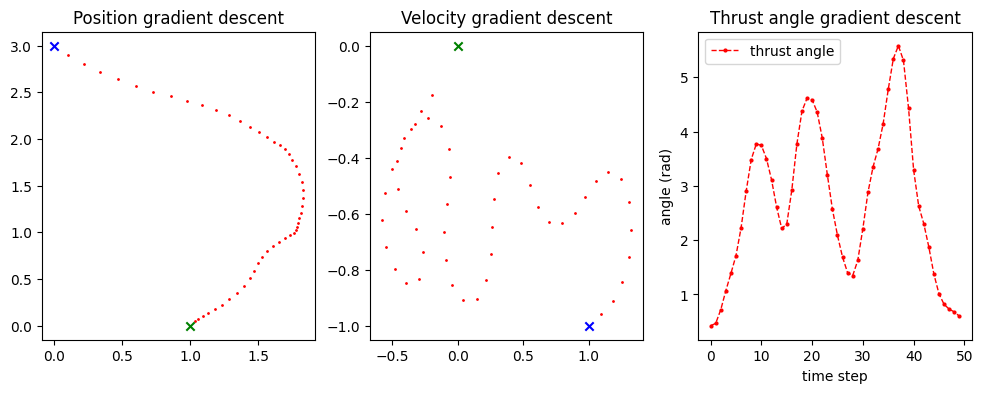

In [39]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


x = x0.copy()
v = v0.copy()
xs = jnp.zeros((simulation_steps, 2))
vs = jnp.zeros((simulation_steps, 2))
for i in range(0, simulation_steps):
    x, v = verlet_step(x, v, dt, m, thrust_thetas_history[-1][i])
    xs = xs.at[i].set(x)
    vs = vs.at[i].set(v)

axs[0].scatter(xs[:, 0], xs[:, 1], color='red', alpha=1.0, marker='o', s=1)
axs[1].scatter(vs[:, 0], vs[:, 1], color='red', alpha=1.0, marker='o', s=1)

axs[0].scatter(xn_star[0], xn_star[1], label='target', color='green', marker='x')
axs[0].scatter(x0[0], x0[1], label='start', color='blue', marker='x')

axs[1].scatter(vn_star[0], vn_star[1], label='target', color='green', marker='x')
axs[1].scatter(v0[0], v0[1], label='start', color='blue', marker='x')


axs[2].plot(thrust_thetas_history[-1], label='thrust angle', color='red', marker='o', markersize=2, linestyle='dashed', linewidth=1)
axs[2].set_title('Thrust angle')
axs[2].set_xlabel('time step')
axs[2].set_ylabel('angle (rad)')


axs[0].set_title('Position gradient descent')
axs[1].set_title('Velocity gradient descent')
axs[2].set_title('Thrust angle gradient descent')



plt.legend()
